In [60]:
import tensorflow_hub as hub
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
AUTOTUNE = tf.data.experimental.AUTOTUNE


In [76]:
m = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/tensorflow/efficientnet/b7/classification/1")
])


In [6]:
ds_train, ds_test, attack_images, attack_labels = load_data("imagenette")

In [77]:
res = m.predict(tf.expand_dims(attack_images[7], 0))

In [78]:
import numpy as np
for x in res:
    print(np.argmax(tf.nn.softmax(x)))


569


In [105]:
import foolbox as fb

fmodel = fb.models.TensorFlowModel(m, bounds=(0,1))
attack = fb.attacks.L2CarliniWagnerAttack(confidence=.5)
advs, clipped_advs, success = attack(
    fmodel,
    (tf.expand_dims(attack_ images[7], 0)),
    (tf.expand_dims(569,0)),
    epsilons=None
)

In [106]:
np.argmax(tf.nn.softmax(m.predict(advs)))

867

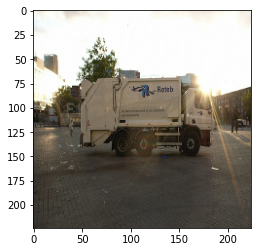

In [107]:
x = plt.imshow(tf.reshape(advs,(224,224,3)))


In [108]:
path='./adv.jpg'
tf.keras.preprocessing.image.save_img(
    path, advs[0]
)


In [96]:
x.savefig('/adv.jpg')

AttributeError: 'AxesImage' object has no attribute 'savefig'

In [5]:
def load_data(dataset,ratio='100%'):

    def augment(image,label):
        #image = tf.image.convert_image_dtype(image, tf.float32)
        #image = tf.image.rot90(image, tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)) # random rotation
        image = tf.image.random_flip_left_right(image)
        #image = tf.image.random_flip_up_down(image)
        #image = tf.image.random_hue(image, 0.08)
        #image = tf.image.random_saturation(image, 0.6, 1.6)
        #image = tf.image.random_contrast(image, 0.7, 1.3)
        #image = tf.image.random_brightness(image, max_delta=0.5) # Random brightness
        image = tf.image.resize_with_crop_or_pad(image, 224+60, 224+60) # Add 60 pixels of padding
        image = tf.image.random_crop(image, size=[224,224,3]) # Random crop back to 28x28
        return image,label
    
    @tf.function
    def load_image(datapoint):
        input_image, label = normalize(datapoint)
        return input_image, label
       
    if dataset=='mnist':
        
        ds, info = tfds.load(name=dataset, with_info=True, split=[f"train[:{ratio}]",f"test[:{ratio}]"])
        ds_train=ds[0]
        ds_test=ds[1]
        
        def normalize(x):
            y = {'image': tf.image.convert_image_dtype(x['image'], tf.float32), 'label': x['label']}
            y = (tf.reshape(y['image'],(28*28,1)), y['label'])
            return y
        ds_test = list(ds_test.map(load_image))
        ds_train = list(ds_train.map(load_image))

        x_train = tf.convert_to_tensor([sample[0] for sample in ds_train])
        y_train = tf.convert_to_tensor([sample[1] for sample in ds_train])
        x_test = tf.convert_to_tensor([sample[0] for sample in ds_test])
        y_test = tf.convert_to_tensor([sample[1] for sample in ds_test])

        return [x_train, y_train], [x_test, y_test], x_test[:1000], y_test[:1000]
        
    if dataset=='imagenette':
        ds, info = tfds.load(name=dataset, with_info=True, split=[f"train[:{ratio}]",f"validation[:{ratio}]"])
        
        ds_train=ds[0]
        ds_test=ds[1]
        def normalize(x):
            y = {'image': tf.image.convert_image_dtype(x['image'], tf.float32), 'label': x['label']}
            y = (tf.image.resize(y['image'], (224,224)), y['label'])
            return y


        num_train_examples= info.splits['train'].num_examples
        BATCH_SIZE = 128

        ds_train = (
            ds_train
            .map(normalize, num_parallel_calls=tf.data.experimental.AUTOTUNE)
            .take(num_train_examples)
            .cache()
            .shuffle(num_train_examples)
            .map(augment, num_parallel_calls=AUTOTUNE)
            .batch(BATCH_SIZE)
            .prefetch(AUTOTUNE)
        ) 

        ds_test = ds_test.map(
            normalize, )
        ds_test = ds_test.batch(BATCH_SIZE)
        ds_test = ds_test.cache()
        ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)



        attack_set = list(ds[1].map(load_image))[:256]

        attack_images = tf.convert_to_tensor([sample[0] for sample in attack_set])
        attack_labels = tf.convert_to_tensor([sample[1] for sample in attack_set])

        return ds_train, ds_test, attack_images, attack_labels
    
    return False